In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from emgen import *
from emgen.samples.danbooru2017 import *
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [13]:
if not t.cuda.is_available():
    print('Should have CUDA for faster computation')

Should have CUDA for faster computation


# Data Preprocessing

In [14]:
# Get JSON
extract_file('danbooru-metadata/danbooru-metadata/201700.json')
json_file = './data/db/201700.json'
json_dicts = read_json(json_file)
id_filter = lambda x: int(x['id']) % 1000 <= 150
id_mag_filter = lambda x: int(x['id']) <= 2_950_000
uploaders, uploader_counts = np.unique([json_dict['uploader_id'] for json_dict in json_dicts],
                             return_counts=True)
sample_size_filter = lambda x: uploader_counts[np.argwhere(x['uploader_id']==uploaders)] >= 50
admin_uploads = lambda x: int(x['uploader_id']) > 100
json_filtered = filter_json(json_dicts,
                            id_filter, # Make sure we have the data in Kaggle
                            id_mag_filter, # ^
                            sample_size_filter, # Make sure we have reliable style samples
                            admin_uploads, # Certain number of users have insane upload numbers
                            rating='s',
                            file_ext='jpg')
# Extract CSV and JPGs
format_workdir(json_filtered)

KeyboardInterrupt: 

# Modeling

In [8]:
model = emgen_model()
dataloader = emgen_dataloader('./data/db/labels.csv', './data/db')

history_cb = GetMetrics()
callbacks = [EarlyStopping(monitor='val_loss',
                           min_delta=.01,
                           patience=5,
                           mode='min',
                           verbose=False),
             history_cb]
trainer = pl.Trainer(max_epochs=10, callbacks=callbacks)
trainer.fit(model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type      | Params
--------------------------------------
0 | relu    | ReLU      | 0     
1 | maxpool | MaxPool2d | 0     
2 | flatten | Flatten   | 0     
3 | linear  | Linear    | 46.1 K
--------------------------------------
46.1 K    Trainable params
0         Non-trainable params
46.1 K    Total params
0.184     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/mnt/c/Users/thema/repos/emgen/env/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/mnt/c/Users/thema/repos/emgen/env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/mnt/c/Users/thema/repos/emgen/env/lib/python3.9/site-packages/pytorch_lightning/trainer/callback_hook.py:102: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

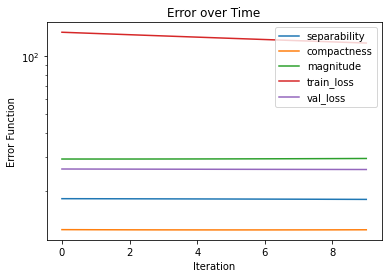

In [9]:
plot_training(history_cb.history_train)

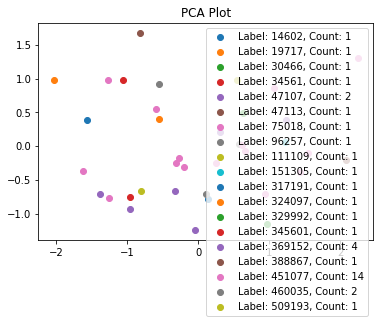

In [10]:
batch = next(iter(dataloader.train_dataloader()))
embeddings = model(batch[0])
labels = batch[1]
pca_visualize(embeddings, labels)